In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.io import mmread
from scipy.sparse import csr_matrix
import pickle as pkl
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

import gc

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
#import seaborn as sns

import scib_metrics as sm
import sys
import os
sys.path.append('/'.join(os.getcwd().split('/')[:-1]+['eval','cleaned','']))
#from metrics import ilisi,asw_batch

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

# Define the path to the directory you want to change to
new_directory = '/scratch365/eaboelno/Integration_NEW'

# Use os.chdir() to change the working directory
os.chdir(new_directory)

# Testing layers and raw and .X in adata

In [2]:
adata = sc.read_h5ad('./cVAE_analysis/human_mouse/adata_m2h_simplified_labeled.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 21541 × 22564
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

In [4]:
print(adata.X[:5, :5])

  (0, 3)	0.29292664


In [5]:
print(adata.raw.X[:5, :5])

  (0, 3)	0.29292664


In [6]:
print("Type of data in .raw attribute:", type(adata.raw))

Type of data in .raw attribute: <class 'anndata._core.raw.Raw'>


In [7]:
print("Type of data in .X attribute:", type(adata.X))

Type of data in .X attribute: <class 'scipy.sparse._csr.csr_matrix'>


In [8]:
adata.X = adata.layers['counts']
del adata.layers["log1p_norm"]

In [9]:
adata=adata[:,np.array((adata.X>0).sum(axis=0)>20).ravel()]
adata

View of AnnData object with n_obs × n_vars = 21541 × 19107
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [10]:
print(adata.X[:5, :5])

  (0, 2)	1
  (1, 4)	5
  (2, 4)	1
  (3, 4)	3
  (4, 4)	3


In [11]:
print(adata.raw.X[:5, :5])

  (0, 3)	0.29292664


In [12]:
del adata.raw

In [13]:
print(adata.raw.X[:5, :5])

AttributeError: 'NoneType' object has no attribute 'X'

In [14]:
adata.raw = adata

In [15]:
print(adata.raw.X[:5, :5])

  (0, 2)	1
  (1, 4)	5
  (2, 4)	1
  (3, 4)	3
  (4, 4)	3


In [16]:
print("Type of data in .X attribute:", type(adata.X))

Type of data in .X attribute: <class 'scipy.sparse._csr.csr_matrix'>


In [17]:
print("Type of data in .raw attribute:", type(adata.raw))

Type of data in .raw attribute: <class 'anndata._core.raw.Raw'>


# Set up data for integrations- HVG

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers["log1p_norm"] = sc.pp.log1p(adata.X)

In [19]:
print(adata.X[:5, :5])

  (0, 2)	0.29305628
  (1, 4)	1.0415423
  (2, 4)	0.31552207
  (3, 4)	0.7569557
  (4, 4)	0.85382694


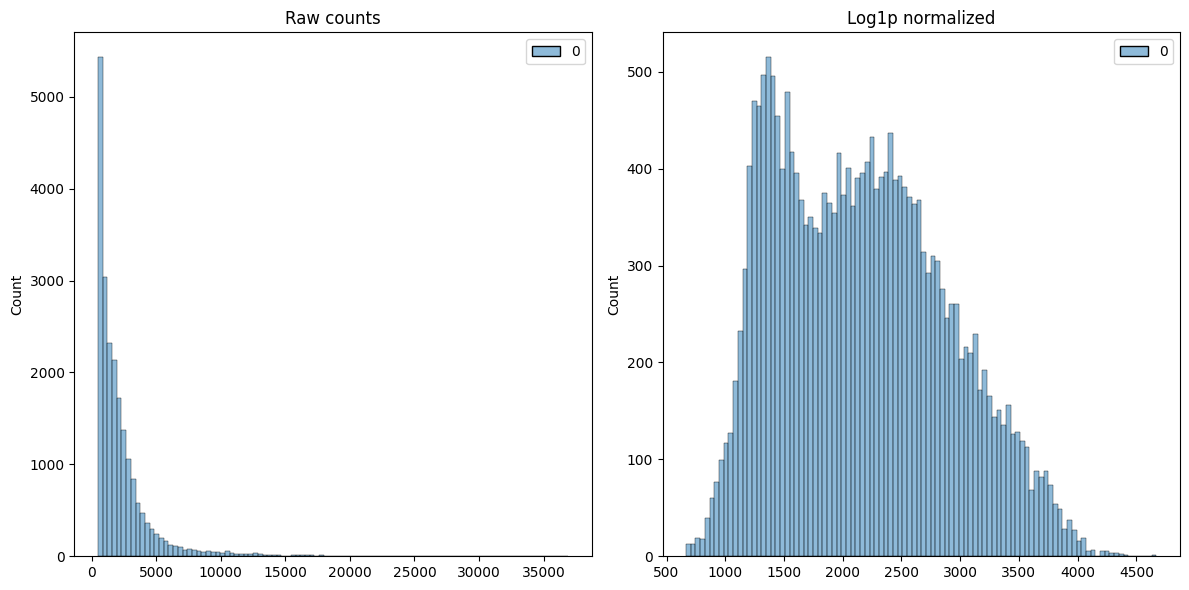

In [20]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot total counts
sns.histplot(adata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Raw counts")

# Plot shifted logarithm
sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Log1p normalized")

plt.tight_layout()
plt.show()

In [24]:
adata.obs

,sample_id,publication,sample_id_anon,individual_id_anon,replicate,treatment,condition,tissue,time,batch,lesion_type,sample_source,diagnosis,n_genes_by_counts,total_counts,pct_counts_mt,pct_counts_ribo,s_score,g2m_score,phase,type_fine,type_broad,cluster_zoom,exclude_pseudobulk,seq_pool,sex,age_at_death,smoker,cause_of_death,years_w_ms,pmi_minutes,age_scale,age_cat,pmi_cat,pmi_cat2,cell_cycle_diff,cell_type_eval,library_type,sample_type,organism,system
barcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CATGAGTTCGTACCTC-1,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,5806.0,29394.0,0.023814,0.176907,-0.170144,-0.111493,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.058651,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
CGTAATGCAACGACTT-1,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,5284.0,27289.0,0.003664,0.146579,-0.102384,-0.142398,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,0.040014,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
GTTCATTCACCTAAAC-1,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,4868.0,26969.0,0.018540,0.140903,-0.125123,-0.133218,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,0.008095,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
AGATGAAGTGCCTTCT-1,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,4931.0,26522.0,0.018852,0.030164,-0.116627,-0.108410,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.008217,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
GGGACCTGTACGGTTT-1,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,4381.0,22259.0,0.004493,0.058403,-0.083980,-0.109401,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,0.025421,excitatory neurons,10X 3p kit v3.1,sn,mouse,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TACGCTCAGGAACATT-1,cn2,(this study),adams_Sample8_2,adams_Sample8,2,Normal,Control,Corpus callosum,Baseline,8,Control,(this study),Control,396.0,500.0,0.000000,0.200000,-0.023631,-0.007056,G1,TBD,oligodendrocytes,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.016575,oligodendrocytes,10X 3p kit v3.1,sn,mouse,0
CGTGAATAGTAAACGT-1,cn2,(this study),adams_Sample8_2,adams_Sample8,2,Normal,Control,Corpus callosum,Baseline,8,Control,(this study),Control,379.0,510.0,0.000000,0.196078,-0.032178,-0.058969,G1,TBD,oligodendrocytes,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,0.026790,oligodendrocytes,10X 3p kit v3.1,sn,mouse,0
GCTCAAACAAGATTGA-1,cn2,(this study),adams_Sample8_2,adams_Sample8,2,Normal,Control,Corpus callosum,Baseline,8,Control,(this study),Control,405.0,508.0,0.000000,0.000000,-0.023514,0.052045,G2M,TBD,oligodendrocytes,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.075559,oligodendrocytes,10X 3p kit v3.1,sn,mouse,0


In [25]:
unique_batches = adata.obs['batch'].unique()

print(unique_batches)

[6, 4, 1, 2, 3, 5, 7, 8]
Categories (8, int64): [1, 2, 3, 4, 5, 6, 7, 8]


In [21]:
sc.pp.highly_variable_genes(
     adata=adata, n_top_genes=10000, flavor='cell_ranger', batch_key='batch')
adata.shape

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

(21541, 19107)

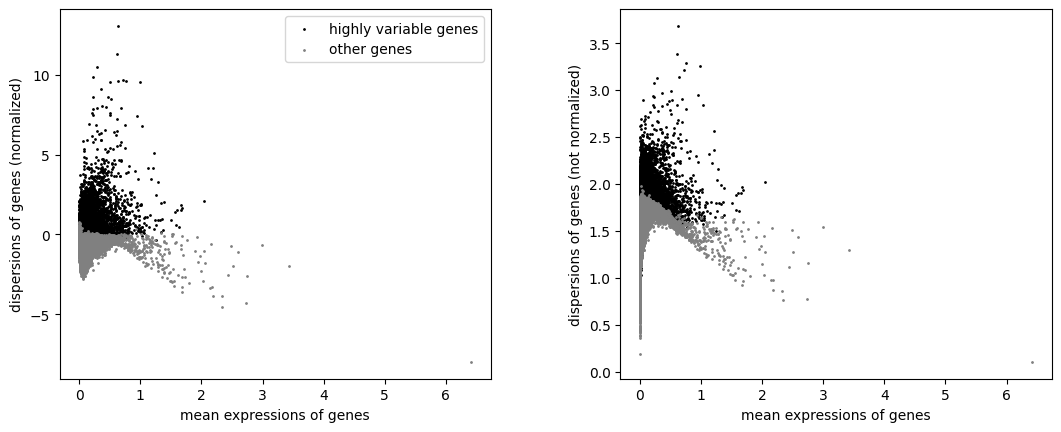

In [22]:
sc.pl.highly_variable_genes(adata)

highly_variable_nbatches
8    2561
6    2281
5    2168
4    2135
0    2102
3    2102
7    2075
2    1932
1    1751
Name: count, dtype: int64

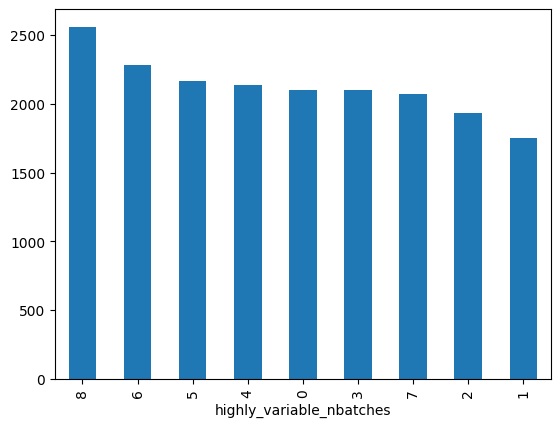

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [26]:
adata.write_h5ad('./cVAE_analysis/sysVI/adata_hvg_updatedX.h5ad')

# Repeat for pandey and shen

In [2]:
pdata = sc.read_h5ad('./cVAE_analysis/human_mouse/pdata_m2h_simplified_labeled.h5ad')
#sdata = sc.read_h5ad('./cVAE_analysis/human_mouse/sdata_m2h_simplified_labeled.h5ad')

In [3]:
pdata

AnnData object with n_obs × n_vars = 41938 × 23111
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

In [4]:
pdata.X = pdata.layers['counts']
del pdata.layers["log1p_norm"]
del pdata.raw

In [5]:
pdata=pdata[:,np.array((pdata.X>0).sum(axis=0)>20).ravel()]
pdata

View of AnnData object with n_obs × n_vars = 41938 × 20384
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [6]:
pdata.raw = pdata

In [7]:
sc.pp.normalize_total(pdata, target_sum=1e4)
pdata.layers["log1p_norm"] = sc.pp.log1p(pdata.X)

In [8]:
print(pdata.X[:10, :10])

  (0, 3)	0.18772767
  (0, 4)	0.18772767
  (0, 6)	0.34572205
  (1, 2)	0.4824902
  (1, 5)	0.6025685
  (1, 6)	0.8948255
  (1, 7)	0.6025685
  (2, 6)	0.89661384
  (2, 7)	0.34688488
  (2, 9)	0.18840878
  (3, 2)	0.35401866
  (3, 6)	0.49297076
  (3, 7)	0.6149497
  (3, 9)	0.35401866
  (4, 2)	0.6173593
  (4, 4)	0.19351403
  (4, 5)	0.19351403
  (4, 6)	0.49501282
  (4, 7)	0.49501282
  (5, 2)	0.19856383
  (5, 6)	0.8406613
  (5, 7)	0.63052654
  (5, 9)	0.19856383
  (6, 2)	0.2009823
  (6, 5)	0.2009823
  (6, 6)	0.63679504
  (6, 7)	0.511511
  (6, 9)	0.36825204
  (7, 2)	0.36867082
  (7, 5)	0.36867082
  (7, 6)	0.5120553
  (7, 7)	0.8490541
  (7, 9)	0.20122983
  (8, 2)	0.51355153
  (8, 6)	0.36982226
  (8, 7)	0.6391949
  (8, 9)	0.20191066
  (9, 2)	0.5138662
  (9, 5)	0.20205393
  (9, 6)	0.20205393
  (9, 7)	1.0265118


In [9]:
print(pdata.raw.X[:10, :10])

  (0, 3)	1
  (0, 4)	1
  (0, 6)	2
  (1, 2)	3
  (1, 5)	4
  (1, 6)	7
  (1, 7)	4
  (2, 6)	7
  (2, 7)	2
  (2, 9)	1
  (3, 2)	2
  (3, 6)	3
  (3, 7)	4
  (3, 9)	2
  (4, 2)	4
  (4, 4)	1
  (4, 5)	1
  (4, 6)	3
  (4, 7)	3
  (5, 2)	1
  (5, 6)	6
  (5, 7)	4
  (5, 9)	1
  (6, 2)	1
  (6, 5)	1
  (6, 6)	4
  (6, 7)	3
  (6, 9)	2
  (7, 2)	2
  (7, 5)	2
  (7, 6)	3
  (7, 7)	6
  (7, 9)	1
  (8, 2)	3
  (8, 6)	2
  (8, 7)	4
  (8, 9)	1
  (9, 2)	3
  (9, 5)	1
  (9, 6)	1
  (9, 7)	8


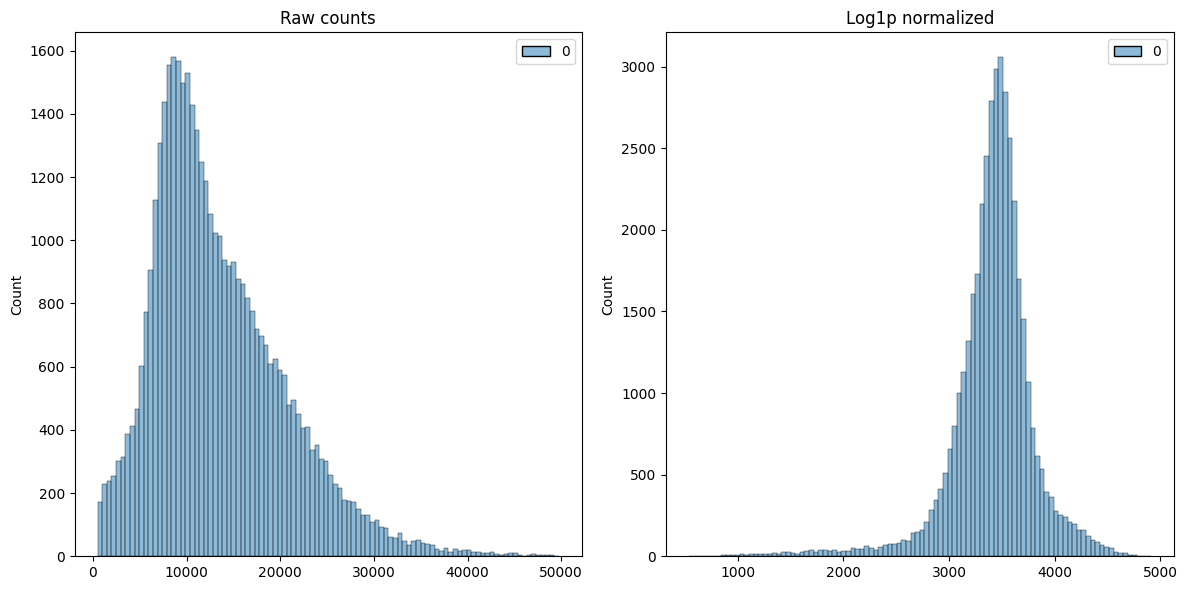

In [10]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot total counts
sns.histplot(pdata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Raw counts")

# Plot shifted logarithm
sns.histplot(pdata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Log1p normalized")

plt.tight_layout()
plt.show()

In [11]:
sc.pp.highly_variable_genes(
     adata=pdata, n_top_genes=10000, flavor='cell_ranger', batch_key='batch')

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

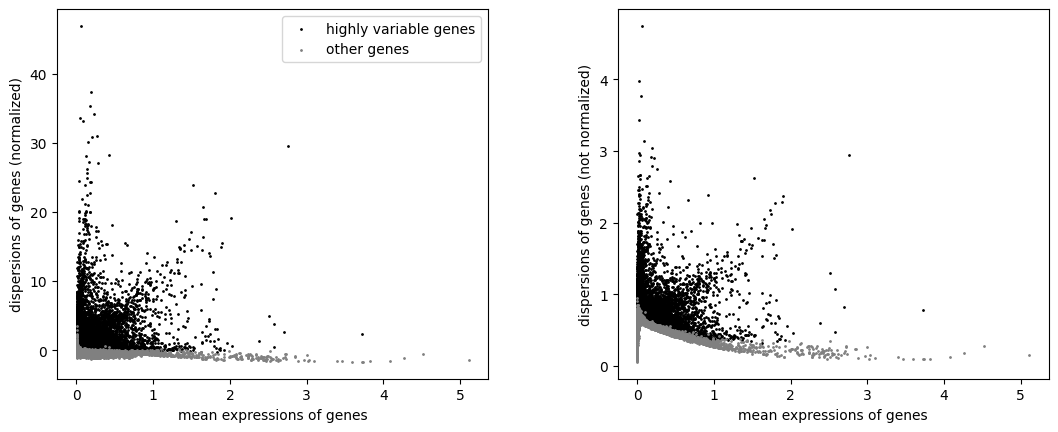

In [12]:
sc.pl.highly_variable_genes(pdata)

In [13]:
pdata.write_h5ad('./cVAE_analysis/sysVI/pdata_hvg_updatedX.h5ad')

In [14]:
#pdata = sc.read_h5ad('./cVAE_analysis/human_mouse/pdata_m2h_simplified_labeled.h5ad')
sdata = sc.read_h5ad('./cVAE_analysis/human_mouse/sdata_m2h_simplified_labeled.h5ad')

In [15]:
sdata

AnnData object with n_obs × n_vars = 48734 × 21096
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

In [16]:
sdata.X = sdata.layers['counts']
del sdata.layers["log1p_norm"]
del sdata.raw
sdata=sdata[:,np.array((sdata.X>0).sum(axis=0)>20).ravel()]
sdata

View of AnnData object with n_obs × n_vars = 48734 × 18322
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [17]:
sdata.raw = sdata

In [18]:
sc.pp.normalize_total(sdata, target_sum=1e4)
sdata.layers["log1p_norm"] = sc.pp.log1p(sdata.X)

In [19]:
print(sdata.X[:10, :10])

  (0, 4)	0.93436444
  (0, 5)	0.93436444
  (0, 6)	0.93436444
  (1, 1)	1.3971543
  (1, 4)	0.92498815
  (2, 1)	1.0110762
  (2, 4)	1.0110762
  (2, 6)	1.0110762
  (3, 6)	1.0606396
  (3, 7)	1.0606396
  (4, 6)	1.0600227
  (6, 1)	1.0913323
  (7, 5)	1.1027628


In [20]:
print(sdata.raw.X[:10, :10])

  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (1, 1)	2
  (1, 4)	1
  (2, 1)	1
  (2, 4)	1
  (2, 6)	1
  (3, 6)	1
  (3, 7)	1
  (4, 6)	1
  (6, 1)	1
  (7, 5)	1


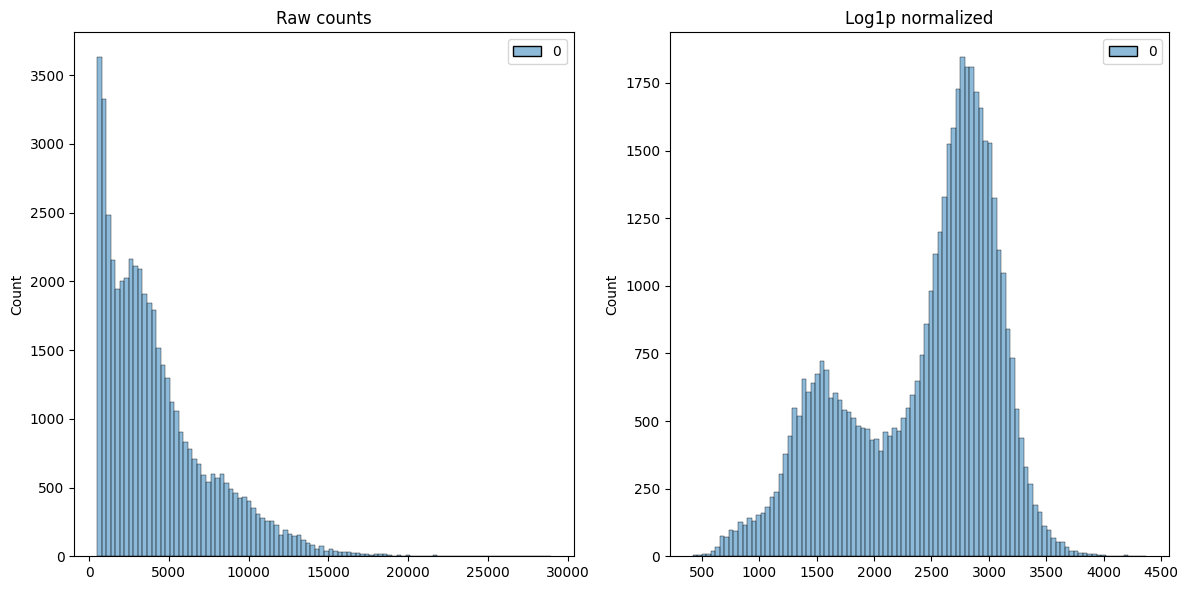

In [21]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot total counts
sns.histplot(sdata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Raw counts")

# Plot shifted logarithm
sns.histplot(sdata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Log1p normalized")

plt.tight_layout()
plt.show()

In [22]:
sc.pp.highly_variable_genes(
     adata=sdata, n_top_genes=10000, flavor='cell_ranger', batch_key='batch')

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

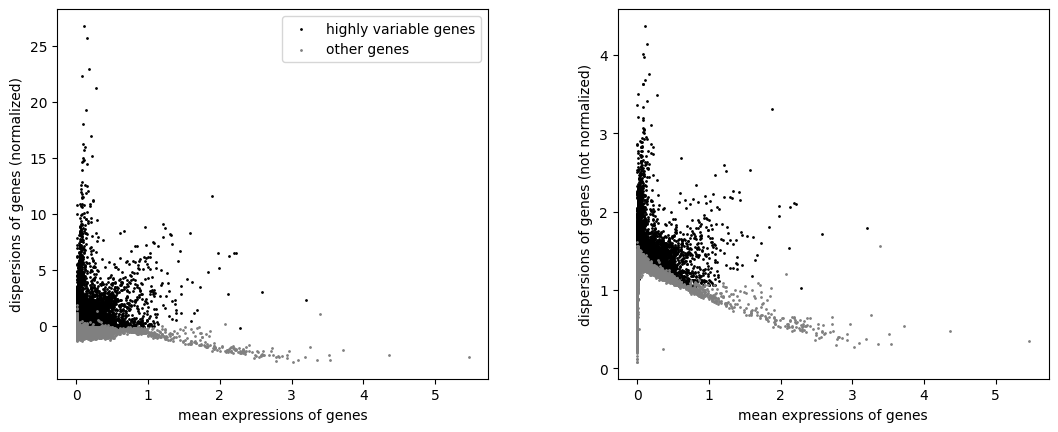

In [23]:
sc.pl.highly_variable_genes(sdata)

In [24]:
sdata.write_h5ad('./cVAE_analysis/sysVI/sdata_hvg_updatedX.h5ad')

highly_variable_nbatches
12    3230
0     2029
2     1822
1     1784
3     1754
4     1647
5     1412
11    1322
6     1305
7     1098
10    1011
8      996
9      974
Name: count, dtype: int64

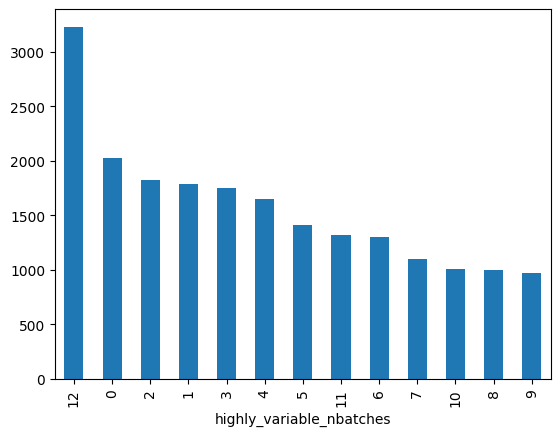

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
n_batches = pdata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

highly_variable_nbatches
4     2322
5     2321
6     2065
3     2047
7     1862
10    1672
8     1619
9     1562
2     1413
1      986
0      453
Name: count, dtype: int64

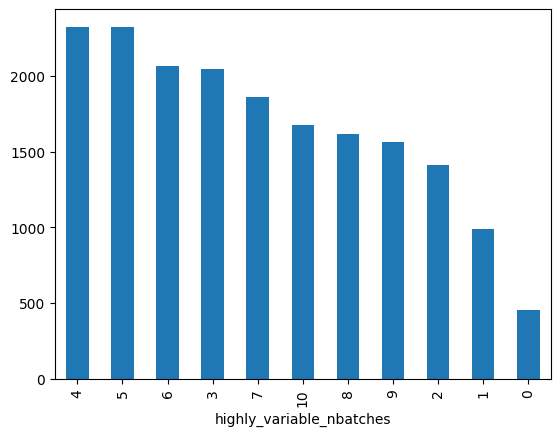

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
n_batches = sdata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

# Find HVG on merged mouse data

In [27]:
adata = sc.read_h5ad('./cVAE_analysis/sysVI/adata_hvg_updatedX.h5ad')
pdata = sc.read_h5ad('./cVAE_analysis/sysVI/pdata_hvg_updatedX.h5ad')
sdata = sc.read_h5ad('./cVAE_analysis/sysVI/sdata_hvg_updatedX.h5ad')

In [28]:
adata

AnnData object with n_obs × n_vars = 21541 × 19107
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [47]:
adata.var

,mouse_gene_id,n_cells,mouse_gene_name,human_gene_name,human_gene_id,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
gene_name,,,,,,,,,,,
0610005C13Rik,ENSMUSG00000109644,156,0610005C13Rik,NaN,NaN,True,0.011130,1.937569,0.321301,6,False
0610009B22Rik,ENSMUSG00000007777,280,0610009B22Rik,NaN,NaN,False,0.015900,1.365814,-0.620766,1,False
0610009E02Rik,ENSMUSG00000086714,416,0610009E02Rik,NaN,NaN,False,0.025459,1.725836,-0.403202,2,False
0610009L18Rik,ENSMUSG00000043644,164,0610009L18Rik,NaN,NaN,True,0.009225,1.798777,-0.017442,6,False
0610010F05Rik,ENSMUSG00000042208,2648,0610010F05Rik,NaN,ENSG00000162929,False,0.181715,1.649911,-1.199714,0,False
...,...,...,...,...,...,...,...,...,...,...,...
mt-Nd3,ENSMUSG00000064360,110,mt-Nd3,MT-ND3,ENSG00000198840,False,0.007755,1.483861,-0.538332,2,False
mt-Nd4,ENSMUSG00000064363,913,mt-Nd4,MT-ND4,ENSG00000198886,False,0.070941,1.771368,-0.336554,4,False
mt-Nd4l,ENSMUSG00000065947,154,mt-Nd4l,MT-ND4L,ENSG00000212907,False,0.011444,1.642010,-0.344349,4,False


In [29]:
pdata

AnnData object with n_obs × n_vars = 41938 × 20384
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [30]:
sdata

AnnData object with n_obs × n_vars = 48734 × 18322
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [52]:
# Create an empty dictionary to store the mapping
gene_id_mapping = {}

# Iterate through each AnnData object and create the mapping
for ad in [adata, pdata, sdata]:
    if 'mouse_gene_id' in ad.var.columns:
        # Iterate through the genes in this AnnData object
        for gene, mouse_gene_id in zip(ad.var.index, ad.var['mouse_gene_id']):
            gene_id_mapping[gene] = mouse_gene_id

            # Print the combined dictionary
print(list(gene_id_mapping.items())[:10])

[('0610005C13Rik', 'ENSMUSG00000109644'), ('0610009B22Rik', 'ENSMUSG00000007777'), ('0610009E02Rik', 'ENSMUSG00000086714'), ('0610009L18Rik', 'ENSMUSG00000043644'), ('0610010F05Rik', 'ENSMUSG00000042208'), ('0610010K14Rik', 'ENSMUSG00000020831'), ('0610012G03Rik', 'ENSMUSG00000107002'), ('0610030E20Rik', 'ENSMUSG00000058706'), ('0610038B21Rik', 'ENSMUSG00000097882'), ('0610040B10Rik', 'ENSMUSG00000089889')]


In [53]:
len(gene_id_mapping)

21411

In [31]:
adata_mm=sc.concat([adata, pdata, sdata],
                join='outer',
                index_unique='_', keys=['adams','pandey', 'shen'])
adata_mm

AnnData object with n_obs × n_vars = 112213 × 21411
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    layers: 'counts', 'log1p_norm'

In [32]:
sc.pp.filter_genes(adata_mm, min_cells=3)
adata_mm

AnnData object with n_obs × n_vars = 112213 × 21411
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'n_cells'
    layers: 'counts', 'log1p_norm'

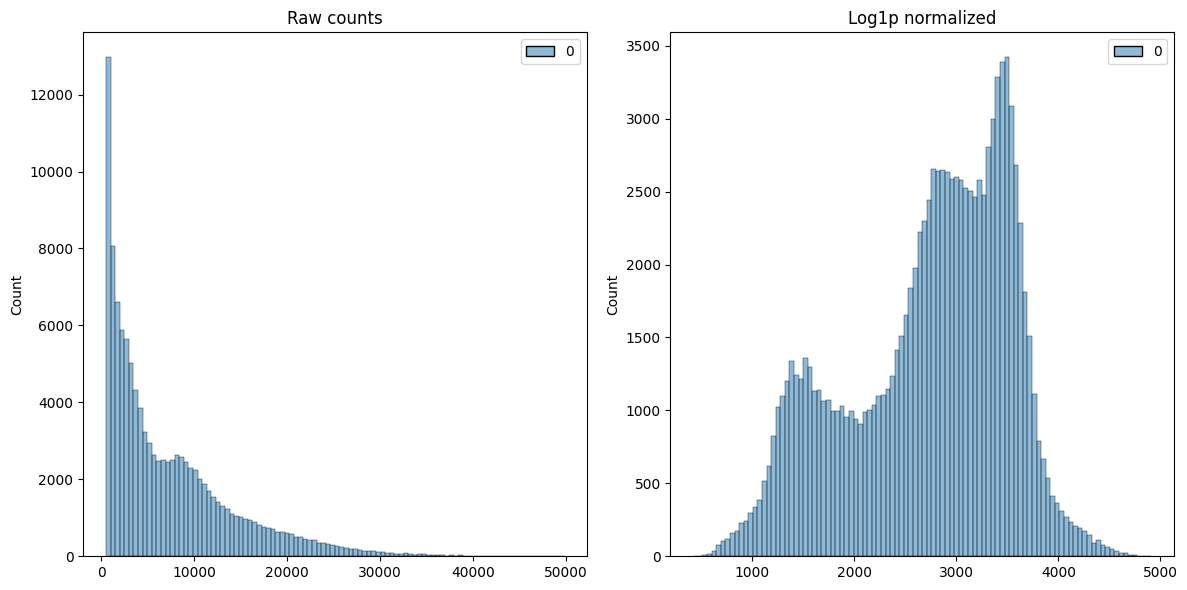

In [33]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot total counts
sns.histplot(adata_mm.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Raw counts")

# Plot shifted logarithm
sns.histplot(adata_mm.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Log1p normalized")

plt.tight_layout()
plt.show()

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: T

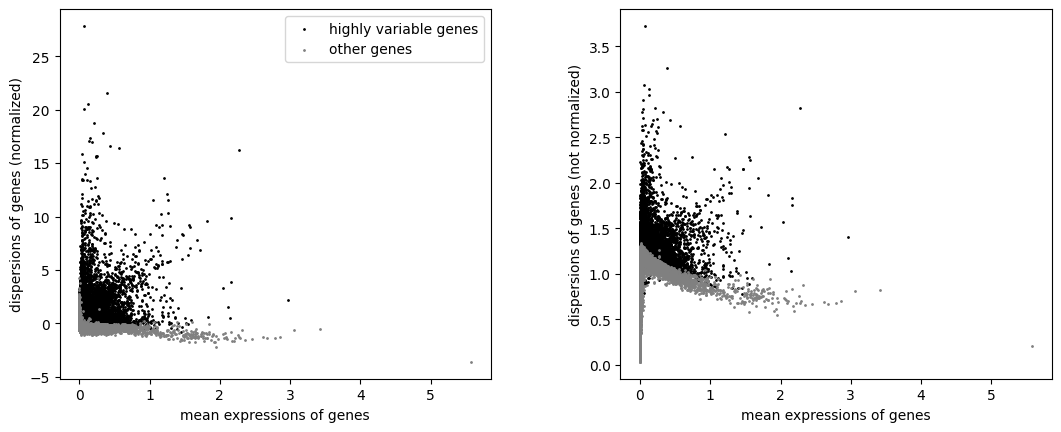

In [34]:
sc.pp.highly_variable_genes(
     adata=adata_mm, n_top_genes=10000, flavor='cell_ranger', batch_key='batch')
sc.pl.highly_variable_genes(adata_mm)

In [35]:
print(adata_mm.X[:10, :10])

  (0, 3)	0.29305628
  (0, 7)	0.5194106
  (0, 9)	0.5194106
  (1, 5)	1.0415423
  (1, 7)	0.55010414
  (1, 9)	0.3124113
  (2, 5)	0.31552207
  (2, 7)	0.74807316
  (2, 9)	0.31552207
  (3, 5)	0.7569557
  (4, 5)	0.85382694
  (5, 5)	0.41221035
  (6, 5)	1.1173232
  (7, 5)	1.307015
  (8, 0)	0.44250843
  (8, 3)	0.44250843
  (8, 5)	0.74820995
  (9, 5)	0.75678545
  (9, 7)	0.75678545


In [36]:
print(adata_mm.raw.X[:10, :10])

  (0, 9)	2
  (0, 7)	2
  (0, 3)	1
  (1, 9)	1
  (1, 7)	2
  (1, 5)	5
  (2, 9)	1
  (2, 7)	3
  (2, 5)	1
  (3, 5)	3
  (4, 5)	3
  (5, 5)	1
  (6, 5)	4
  (7, 5)	5
  (8, 5)	2
  (8, 3)	1
  (8, 0)	1
  (9, 7)	2
  (9, 5)	2


# Add back var IDs

In [38]:
adata_mm.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
gene_name,,,,,,,
0610005C13Rik,370,True,0.004559,1.285572,0.233436,18,False
0610006L08Rik,21,False,0.000140,0.131026,0.120278,4,False
0610009B22Rik,20931,False,0.152768,0.997471,-0.753077,3,False
0610009E02Rik,1313,False,0.012557,1.224625,-0.320406,8,False
0610009L18Rik,7284,False,0.051010,1.176881,-0.343663,10,False
...,...,...,...,...,...,...,...
mt-Nd3,62317,False,0.968709,0.810337,-0.811130,2,False
mt-Nd4,84501,False,1.967977,0.690763,-1.457355,4,False
mt-Nd4l,46182,False,0.614403,0.959799,-0.620274,8,False


In [39]:
# Path to the .txt file
file_path = '/scratch365/eaboelno/mart_export_GRCh38_p14_Feb2024.txt'

# Read the .txt file into a pandas DataFrame
ortho = pd.read_csv(file_path, sep=',')

ortho = ortho.rename(columns={
    'Gene stable ID': 'human_gene_id',
    'Gene name': 'human_gene_name',
    'Mouse gene stable ID': 'mouse_gene_id',
    'Mouse gene name': 'mouse_gene_name'
})

ortho

,human_gene_id,human_gene_name,mouse_gene_id,mouse_gene_name
0,ENSG00000210049,MT-TF,NaN,NaN
1,ENSG00000211459,MT-RNR1,NaN,NaN
2,ENSG00000210077,MT-TV,NaN,NaN
3,ENSG00000210082,MT-RNR2,NaN,NaN
4,ENSG00000209082,MT-TL1,NaN,NaN
...,...,...,...,...
77797,ENSG00000288629,NaN,NaN,NaN
77798,ENSG00000288678,NaN,NaN,NaN
77799,ENSG00000290825,DDX11L2,NaN,NaN
77800,ENSG00000227232,WASH7P,NaN,NaN


In [40]:
mm_add_geneid=dict(zip(ortho['mouse_gene_name'], ortho['mouse_gene_id']))
for key, value in list(mm_add_geneid.items())[:10]:
    print(f"{key}: {value}")  
len(mm_add_geneid)

nan: nan
mt-Nd1: ENSMUSG00000064341
mt-Nd2: ENSMUSG00000064345
mt-Co1: ENSMUSG00000064351
mt-Co2: ENSMUSG00000064354
mt-Atp8: ENSMUSG00000064356
mt-Atp6: ENSMUSG00000064357
mt-Co3: ENSMUSG00000064358
mt-Nd3: ENSMUSG00000064360
mt-Nd4l: ENSMUSG00000065947


20443

In [41]:
adata_mm.var['mouse_gene_id'] = adata_mm.var.index.map(mm_add_geneid)
adata_mm.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mouse_gene_id
gene_name,,,,,,,,
0610005C13Rik,370,True,0.004559,1.285572,0.233436,18,False,NaN
0610006L08Rik,21,False,0.000140,0.131026,0.120278,4,False,NaN
0610009B22Rik,20931,False,0.152768,0.997471,-0.753077,3,False,NaN
0610009E02Rik,1313,False,0.012557,1.224625,-0.320406,8,False,NaN
0610009L18Rik,7284,False,0.051010,1.176881,-0.343663,10,False,NaN
...,...,...,...,...,...,...,...,...
mt-Nd3,62317,False,0.968709,0.810337,-0.811130,2,False,ENSMUSG00000064360
mt-Nd4,84501,False,1.967977,0.690763,-1.457355,4,False,ENSMUSG00000064363
mt-Nd4l,46182,False,0.614403,0.959799,-0.620274,8,False,ENSMUSG00000065947


In [42]:
# Assuming 'mouse_gene_id' is a column in adata_mm.var
nan_count = adata_mm.var['mouse_gene_id'].isna().sum()

print("Number of NaN values in 'mouse_gene_id':", nan_count)

Number of NaN values in 'mouse_gene_id': 6315


In [54]:
adata_mm.var['mouse_gene_id'] = adata_mm.var.index.map(gene_id_mapping.get)
adata_mm.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mouse_gene_id
gene_name,,,,,,,,
0610005C13Rik,370,True,0.004559,1.285572,0.233436,18,False,ENSMUSG00000109644
0610006L08Rik,21,False,0.000140,0.131026,0.120278,4,False,ENSMUSG00000108652
0610009B22Rik,20931,False,0.152768,0.997471,-0.753077,3,False,ENSMUSG00000007777
0610009E02Rik,1313,False,0.012557,1.224625,-0.320406,8,False,ENSMUSG00000086714
0610009L18Rik,7284,False,0.051010,1.176881,-0.343663,10,False,ENSMUSG00000043644
...,...,...,...,...,...,...,...,...
mt-Nd3,62317,False,0.968709,0.810337,-0.811130,2,False,ENSMUSG00000064360
mt-Nd4,84501,False,1.967977,0.690763,-1.457355,4,False,ENSMUSG00000064363
mt-Nd4l,46182,False,0.614403,0.959799,-0.620274,8,False,ENSMUSG00000065947


In [43]:
adata_mm.obs['batch'] = adata_mm.obs['batch'].astype(str)

In [55]:
adata_mm.write_h5ad('./cVAE_analysis/sysVI/adata_mm_hvg.h5ad')

In [56]:
adata_mm_sub = adata_mm[:, adata_mm.var["highly_variable"]].copy()

In [57]:
# Assuming 'mouse_gene_id' is a column in adata_mm.var
nan_count = adata_mm_sub.var['mouse_gene_id'].isna().sum()

print("Number of NaN values in adata_sub 'mouse_gene_id':", nan_count)

Number of NaN values in adata_sub 'mouse_gene_id': 0


In [58]:
adata_mm_sub.write_h5ad('./cVAE_analysis/sysVI/adata_mm_hvg_sub.h5ad')

# Explore HVG overlap in single vs merged mm data

In [59]:
adata_sub = adata[:, adata.var["highly_variable"]].copy()
adata_sub

AnnData object with n_obs × n_vars = 21541 × 10000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [60]:
pdata_sub = pdata[:, pdata.var["highly_variable"]].copy()
pdata_sub

AnnData object with n_obs × n_vars = 41938 × 10000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [61]:
sdata_sub = sdata[:, sdata.var["highly_variable"]].copy()
sdata_sub

AnnData object with n_obs × n_vars = 48734 × 10000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [62]:
# Shared HVGs
shared_hvgs=list(set(adata_sub.var_names) & set(pdata_sub.var_names) & 
                 set(sdata_sub.var_names))
len(shared_hvgs)

4223

In [64]:
common_hvgs=list(set(shared_hvgs) & set(adata_mm_sub.var_names))
len(shared_hvgs)

4223

highly_variable_nbatches
10    972
6     959
12    957
8     947
11    933
13    924
7     920
9     899
14    896
5     856
15    809
16    772
17    766
4     733
20    691
22    689
3     681
19    658
18    652
21    628
27    560
23    555
24    553
26    545
2     530
25    507
28    436
29    393
1     381
30    330
0     279
Name: count, dtype: int64

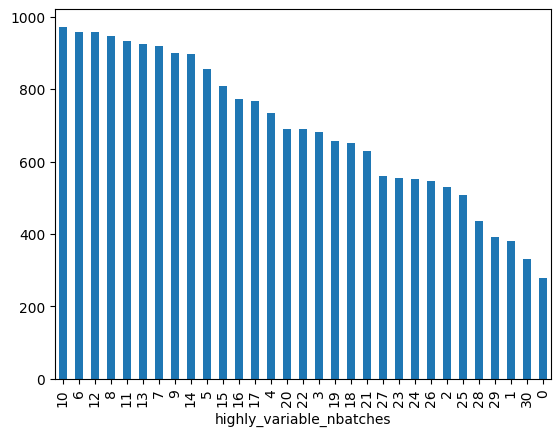

In [65]:
n_batches = adata_mm.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

highly_variable_nbatches
8    2561
6    2281
5    2168
4    2135
0    2102
3    2102
7    2075
2    1932
1    1751
Name: count, dtype: int64

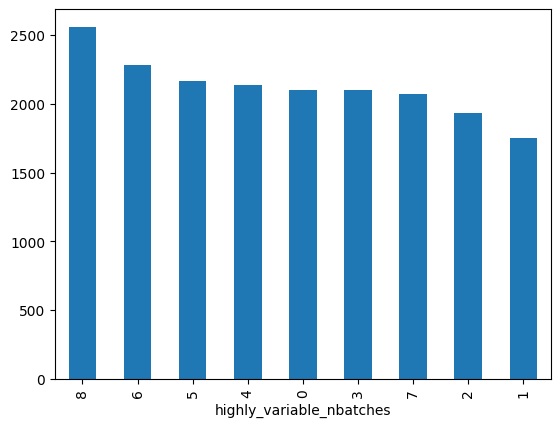

In [66]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

highly_variable_nbatches
12    3230
0     2029
2     1822
1     1784
3     1754
4     1647
5     1412
11    1322
6     1305
7     1098
10    1011
8      996
9      974
Name: count, dtype: int64

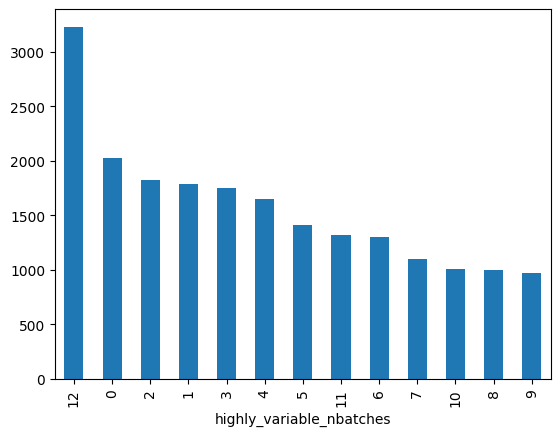

In [68]:
n_batches = pdata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

highly_variable_nbatches
4     2322
5     2321
6     2065
3     2047
7     1862
10    1672
8     1619
9     1562
2     1413
1      986
0      453
Name: count, dtype: int64

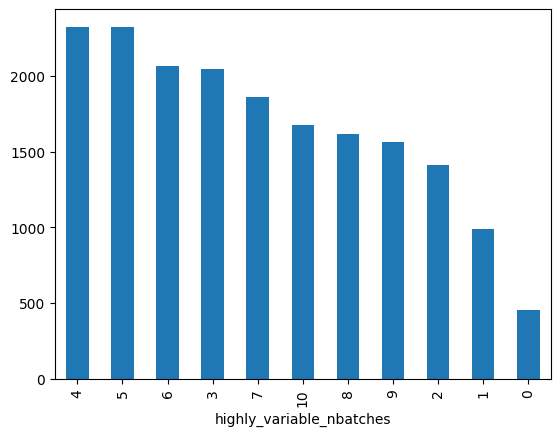

In [69]:
n_batches = sdata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

highly_variable_nbatches
15    809
16    772
17    766
20    691
22    689
19    658
18    652
21    628
27    560
23    555
24    553
26    545
25    507
14    456
28    436
29    393
30    330
Name: count, dtype: int64

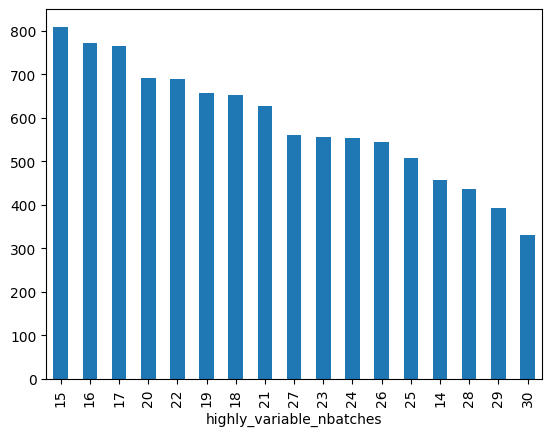

In [70]:
n_batches = adata_mm_sub.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

highly_variable_nbatches
8    2561
6    2281
5    2168
7    2075
4     915
Name: count, dtype: int64

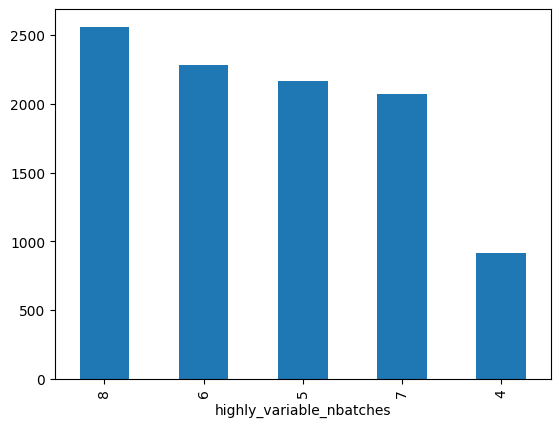

In [67]:
n_batches = adata_sub.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

highly_variable_nbatches
12    3230
11    1322
6     1305
7     1098
10    1011
8      996
9      974
5       64
Name: count, dtype: int64

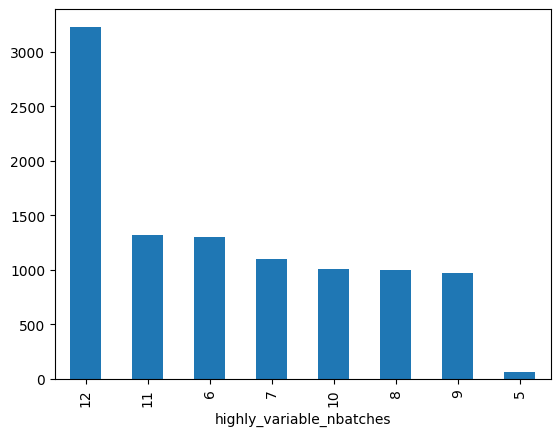

In [71]:
n_batches = pdata_sub.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

highly_variable_nbatches
6     2065
7     1862
10    1672
8     1619
9     1562
5     1220
Name: count, dtype: int64

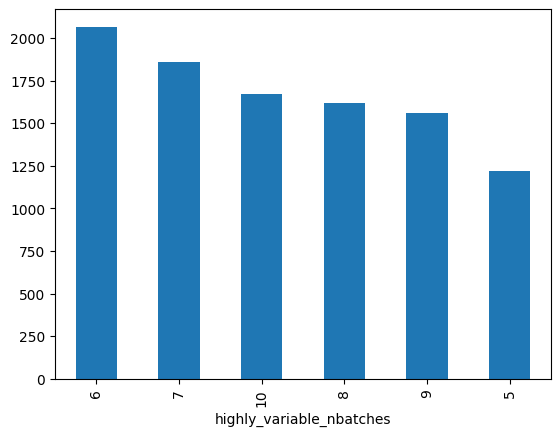

In [72]:
n_batches = sdata_sub.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

# Find shared genes and concat

In [2]:
adata_mm = sc.read_h5ad('./cVAE_analysis/sysVI/adata_mm_hvg_sub.h5ad')
adata_mm

AnnData object with n_obs × n_vars = 112213 × 10000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mouse_gene_id'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [3]:
mdata = sc.read_h5ad("./cVAE_analysis/sysVI/mdata_mm_hvg_sub.h5ad")
mdata

AnnData object with n_obs × n_vars = 335694 × 10000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [7]:
print(adata_mm.X[:10, :10])

  (0, 2)	0.5194106
  (1, 1)	1.0415423
  (1, 2)	0.3124113
  (1, 5)	0.3124113
  (2, 1)	0.31552207
  (2, 2)	0.31552207
  (3, 1)	0.7569557
  (4, 1)	0.85382694
  (4, 5)	0.3712457
  (4, 7)	0.3712457
  (5, 1)	0.41221035
  (5, 4)	0.703248
  (6, 1)	1.1173232
  (6, 9)	0.41486433
  (7, 1)	1.307015
  (8, 0)	0.44250843
  (8, 1)	0.74820995
  (8, 3)	0.44250843
  (8, 4)	0.44250843
  (8, 7)	0.44250843
  (9, 1)	0.75678545
  (9, 4)	0.44833738
  (9, 7)	0.44833738


In [8]:
print(mdata.X[:10, :10])

  (3, 0)	2.1317280276818393
  (8, 2)	0.17572952428757385


In [9]:
print(adata_mm.raw.X[:10, :10])

  (0, 9)	2
  (0, 7)	2
  (0, 3)	1
  (1, 9)	1
  (1, 7)	2
  (1, 5)	5
  (2, 9)	1
  (2, 7)	3
  (2, 5)	1
  (3, 5)	3
  (4, 5)	3
  (5, 5)	1
  (6, 5)	4
  (7, 5)	5
  (8, 5)	2
  (8, 3)	1
  (8, 0)	1
  (9, 7)	2
  (9, 5)	2


In [10]:
print(mdata.raw.X[:10, :10])

  (2, 7)	2.0
  (7, 7)	2.0
  (8, 7)	1.0


In [11]:
# Check the dimensions of mdata.X
print("Dimensions of adata_mm.X:", adata_mm.X.shape)

# Check the dimensions of mdata.raw
print("Dimensions of adata_mm.raw:", adata_mm.raw.X.shape)

Dimensions of adata_mm.X: (112213, 10000)
Dimensions of adata_mm.raw: (112213, 21411)


In [12]:
# Check the dimensions of mdata.X
print("Dimensions of mdata.X:", mdata.X.shape)

# Check the dimensions of mdata.raw
print("Dimensions of mdata.raw:", mdata.raw.X.shape)

Dimensions of mdata.X: (335694, 10000)
Dimensions of mdata.raw: (335694, 30936)


# Reset var names for human/mouse merging

In [62]:
var_dtype = adata_mm.var.dtypes

print("Data type of each column in adata_mm.var:")
print(var_dtype)

Data type of each column in adata_mm.var:
n_cells                           int64
highly_variable                    bool
means                           float64
dispersions                     float64
dispersions_norm                float32
highly_variable_nbatches          int64
highly_variable_intersection       bool
mouse_gene_id                    object
dtype: object


In [63]:
var_dtype = mdata.var.dtypes

print("Data type of each column in adata_mm.var:")
print(var_dtype)

Data type of each column in adata_mm.var:
human_gene_id                     object
n_cells                            int64
mouse_gene_id                   category
mouse_gene_name                 category
human_gene_name                   object
highly_variable                     bool
means                            float64
dispersions                      float64
dispersions_norm                 float32
highly_variable_nbatches           int64
highly_variable_intersection        bool
dtype: object


In [64]:
var_indices = adata_mm.var.index

print("Content of indices in adata_mm.var:")
print(var_indices)

Content of indices in adata_mm.var:
Index(['0610005C13Rik', '0610010F05Rik', '0610030E20Rik', '0610040B10Rik',
       '0610040J01Rik', '0610043K17Rik', '1110002J07Rik', '1110002L01Rik',
       '1110015O18Rik', '1110017D15Rik',
       ...
       'Zswim3', 'Zswim4', 'Zswim5', 'Zswim6', 'Zup1', 'Zwint', 'Zyg11b',
       'Zyx', 'Zzz3', 'a'],
      dtype='object', name='gene_name', length=10000)


In [65]:
var_indices = mdata.var.index

print("Content of indices in adata_mm.var:")
print(var_indices)

Content of indices in adata_mm.var:
Index(['LINC02593', 'SAMD11', 'HES4', 'ISG15', 'LINC01342', 'TNFRSF18',
       'TNFRSF4', 'MXRA8', 'ANKRD65', 'TMEM88B',
       ...
       'MT-CO1', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND4L', 'MT-ND4', 'MT-ND5',
       'MT-ND6', 'MT-CYB', 'AC011841.1'],
      dtype='object', length=10000)


In [66]:
mdata.var

,human_gene_id,n_cells,mouse_gene_id,mouse_gene_name,human_gene_name,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
LINC02593,ENSG00000223764,1087,NaN,NaN,LINC02593,True,0.003719,1.102906,0.498355,40,False
SAMD11,ENSG00000187634,4620,ENSMUSG00000096351,Samd11,SAMD11,True,0.015315,1.314094,0.642744,54,False
HES4,ENSG00000188290,14105,NaN,NaN,HES4,True,0.033982,1.418913,1.056016,57,False
ISG15,ENSG00000187608,9071,ENSMUSG00000035692,Isg15,ISG15,True,0.026043,1.342449,0.483112,45,False
LINC01342,ENSG00000223823,529,NaN,NaN,LINC01342,True,0.001404,0.904957,0.288703,35,False
...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4,ENSG00000198886,222026,ENSMUSG00000064363,mt-Nd4,MT-ND4,True,2.227328,0.928413,-0.816503,34,False
MT-ND5,ENSG00000198786,144526,ENSMUSG00000064367,mt-Nd5,MT-ND5,True,0.960506,1.230078,1.088346,52,False
MT-ND6,ENSG00000198695,15114,ENSMUSG00000064368,mt-Nd6,MT-ND6,True,0.045268,1.374156,0.709094,54,False
MT-CYB,ENSG00000198727,197343,ENSMUSG00000064370,mt-Cytb,MT-CYB,True,1.726084,1.057894,-0.004678,43,False


In [67]:
adata_mm.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mouse_gene_id
gene_name,,,,,,,,
0610005C13Rik,370,True,0.004559,1.285572,0.233436,18,False,ENSMUSG00000109644
0610010F05Rik,15628,True,0.143055,1.152929,-0.171017,17,False,ENSMUSG00000042208
0610030E20Rik,18064,True,0.141184,1.183683,-0.073914,19,False,ENSMUSG00000058706
0610040B10Rik,5496,True,0.049141,1.269363,0.008722,15,False,ENSMUSG00000089889
0610040J01Rik,19880,True,0.180434,1.386197,2.097934,30,True,ENSMUSG00000060512
...,...,...,...,...,...,...,...,...
Zwint,28722,True,0.228307,1.080016,-0.391719,16,False,ENSMUSG00000019923
Zyg11b,22202,True,0.202591,1.180633,0.212724,21,False,ENSMUSG00000034636
Zyx,27621,True,0.199258,1.185623,0.270827,22,False,ENSMUSG00000029860


In [4]:
adata_mm.var_names = adata_mm.var_names.map(lambda x: x.upper())
adata_mm.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mouse_gene_id
gene_name,,,,,,,,
0610005C13RIK,370,True,0.004559,1.285572,0.233436,18,False,ENSMUSG00000109644
0610010F05RIK,15628,True,0.143055,1.152929,-0.171017,17,False,ENSMUSG00000042208
0610030E20RIK,18064,True,0.141184,1.183683,-0.073914,19,False,ENSMUSG00000058706
0610040B10RIK,5496,True,0.049141,1.269363,0.008722,15,False,ENSMUSG00000089889
0610040J01RIK,19880,True,0.180434,1.386197,2.097934,30,True,ENSMUSG00000060512
...,...,...,...,...,...,...,...,...
ZWINT,28722,True,0.228307,1.080016,-0.391719,16,False,ENSMUSG00000019923
ZYG11B,22202,True,0.202591,1.180633,0.212724,21,False,ENSMUSG00000034636
ZYX,27621,True,0.199258,1.185623,0.270827,22,False,ENSMUSG00000029860


In [5]:
# Get gene names from each data frame
genes_adata_mm = set(adata_mm.var_names)
genes_mdata_h2m = set(mdata.var_names)

# Find the intersection of genes among the data frames
intersecting_genes = genes_adata_mm.intersection(genes_mdata_h2m)

# Print the number of intersecting genes
print("Number of intersecting genes:", len(intersecting_genes))

Number of intersecting genes: 4598


In [6]:
# Shared HVGs
shared_hvgs=list(set(adata_mm.var_names) & set(mdata.var_names))
len(shared_hvgs)

4598

In [7]:
# Subset to shraed HVGs and concat
# Keys adds a category annotation to each observation (row)
adata_all=sc.concat([adata_mm[:,shared_hvgs], mdata[:,shared_hvgs]],
                join='outer',
                index_unique='_', keys=['mouse', 'macnair'])
adata_all

AnnData object with n_obs × n_vars = 447907 × 4598
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    layers: 'counts', 'log1p_norm'

In [8]:
var_dtype = adata_all.var.dtypes

print("Data type of each column in adata_all.var:")
print(var_dtype)

Data type of each column in adata_all.var:
Series([], dtype: object)


In [9]:
var_indices = adata_all.var.index

print("Content of indices in adata_all.var:")
print(var_indices)

Content of indices in adata_all.var:
Index(['NR4A1', 'ASTN1', 'GFRA1', 'TFRC', 'VTI1A', 'TBC1D30', 'PVALB', 'TENM2',
       'NINJ1', 'SERPINE1',
       ...
       'VASN', 'FILIP1', 'CCDC112', 'MEF2C', 'TRIM25', 'LSM2', 'ATCAY',
       'PSMB8', 'DNAJC1', 'ELOVL2'],
      dtype='object', length=4598)


In [10]:
print(adata_all.raw.X[:10, :10])

  (0, 3)	1.0
  (0, 7)	2.0
  (0, 9)	2.0
  (1, 5)	5.0
  (1, 7)	2.0
  (1, 9)	1.0
  (2, 5)	1.0
  (2, 7)	3.0
  (2, 9)	1.0
  (3, 5)	3.0
  (4, 5)	3.0
  (5, 5)	1.0
  (6, 5)	4.0
  (7, 5)	5.0
  (8, 0)	1.0
  (8, 3)	1.0
  (8, 5)	2.0
  (9, 5)	2.0
  (9, 7)	2.0


In [11]:
print(adata_all.X[:10, :10])

  (0, 1)	1.3148375749588013
  (0, 4)	0.9942110776901245
  (0, 7)	0.5194106101989746
  (1, 0)	0.9029489755630493
  (1, 1)	1.4587199687957764
  (1, 2)	0.3124113082885742
  (1, 3)	0.3124113082885742
  (1, 4)	1.3695892095565796
  (1, 5)	0.3124113082885742
  (1, 7)	1.271729826927185
  (2, 0)	1.280051350593567
  (2, 1)	0.5550050735473633
  (2, 3)	0.31552207469940186
  (2, 4)	0.9098297953605652
  (2, 7)	0.5550050735473633
  (3, 1)	1.0599734783172607
  (3, 2)	0.5621939897537231
  (3, 3)	0.32009515166282654
  (3, 4)	1.6389670372009277
  (3, 7)	0.5621939897537231
  (4, 1)	1.4223308563232422
  (4, 2)	0.6413687467575073
  (4, 4)	1.703909993171692
  (4, 7)	2.869769334793091
  (5, 0)	0.4122103452682495
  (5, 1)	1.4014075994491577
  (5, 3)	0.4122103452682495
  (5, 4)	0.9283995628356934
  (5, 5)	0.4122103452682495
  (5, 7)	2.544236183166504
  (5, 8)	0.4122103452682495
  (6, 1)	0.9331461787223816
  (6, 4)	0.41486433148384094
  (6, 6)	0.41486433148384094
  (6, 7)	3.0222904682159424
  (7, 1)	1.3070149421

In [13]:
def add_years(value):
    if isinstance(value, int):  # Check if the value is an integer
        return str(value) + ' years'  # Convert integer to string and add ' years'
    elif isinstance(value, str) and value.isdigit():  # Check if the value is a string containing only digits
        return value + ' years'
    else:
        return value

# Apply the function to the "time" column in adata_all.obs
adata_all.obs['time'] = adata_all.obs['time'].apply(add_years)

In [17]:
adata_all.obs['batch'] = adata_all.obs['batch'].astype(str)

In [19]:
adata_all.obs['exclude_pseudobulk'] = adata_all.obs['exclude_pseudobulk'].astype(str)

In [21]:
adata_all.obs['age_at_death'] = adata_all.obs['age_at_death'].astype(str)

In [23]:
adata_all.obs['age_scale'] = adata_all.obs['age_scale'].astype(str)

In [ ]:
# Create an empty dictionary to store the mapping
gene_id_mapping = {}



# Iterate through each AnnData object and create the mapping
for ad in [adata, pdata, sdata]:
    if 'mouse_gene_id' in ad.var.columns:
        # Iterate through the genes in this AnnData object
        for gene, mouse_gene_id in zip(ad.var.index, ad.var['mouse_gene_id']):
            gene_id_mapping[gene] = mouse_gene_id

            # Print the combined dictionary
print(list(gene_id_mapping.items())[:10])

In [26]:
mdata.var

,human_gene_id,n_cells,mouse_gene_id,mouse_gene_name,human_gene_name,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
LINC02593,ENSG00000223764,1087,NaN,NaN,LINC02593,True,0.003719,1.102906,0.498355,40,False
SAMD11,ENSG00000187634,4620,ENSMUSG00000096351,Samd11,SAMD11,True,0.015315,1.314094,0.642744,54,False
HES4,ENSG00000188290,14105,NaN,NaN,HES4,True,0.033982,1.418913,1.056016,57,False
ISG15,ENSG00000187608,9071,ENSMUSG00000035692,Isg15,ISG15,True,0.026043,1.342449,0.483112,45,False
LINC01342,ENSG00000223823,529,NaN,NaN,LINC01342,True,0.001404,0.904957,0.288703,35,False
...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4,ENSG00000198886,222026,ENSMUSG00000064363,mt-Nd4,MT-ND4,True,2.227328,0.928413,-0.816503,34,False
MT-ND5,ENSG00000198786,144526,ENSMUSG00000064367,mt-Nd5,MT-ND5,True,0.960506,1.230078,1.088346,52,False
MT-ND6,ENSG00000198695,15114,ENSMUSG00000064368,mt-Nd6,MT-ND6,True,0.045268,1.374156,0.709094,54,False
MT-CYB,ENSG00000198727,197343,ENSMUSG00000064370,mt-Cytb,MT-CYB,True,1.726084,1.057894,-0.004678,43,False


In [28]:
mapper_dict = dict(zip(mdata.var.index, mdata.var['human_gene_id']))

# 2. Use the mapper to add 'human_gene_id' to adata_all
adata_all.var['human_gene_id'] = adata_all.var_names.map(mapper_dict)

In [31]:
adata_all.var

,human_gene_id
NR4A1,ENSG00000123358
ASTN1,ENSG00000152092
GFRA1,ENSG00000151892
TFRC,ENSG00000072274
VTI1A,ENSG00000151532
...,...
LSM2,ENSG00000204392
ATCAY,ENSG00000167654
PSMB8,ENSG00000204264
DNAJC1,ENSG00000136770


In [32]:
mapper_dict = dict(zip(mdata.var.index, mdata.var['mouse_gene_id']))

# 2. Use the mapper to add 'human_gene_id' to adata_all
adata_all.var['mouse_gene_id'] = adata_all.var_names.map(mapper_dict)
adata_all.var

,human_gene_id,mouse_gene_id
NR4A1,ENSG00000123358,ENSMUSG00000023034
ASTN1,ENSG00000152092,ENSMUSG00000026587
GFRA1,ENSG00000151892,ENSMUSG00000025089
TFRC,ENSG00000072274,ENSMUSG00000022797
VTI1A,ENSG00000151532,ENSMUSG00000024983
...,...,...
LSM2,ENSG00000204392,ENSMUSG00000007050
ATCAY,ENSG00000167654,ENSMUSG00000034958
PSMB8,ENSG00000204264,ENSMUSG00000024338
DNAJC1,ENSG00000136770,ENSMUSG00000026740


In [33]:
mapper_dict = dict(zip(mdata.var.index, mdata.var['mouse_gene_name']))

# 2. Use the mapper to add 'human_gene_id' to adata_all
adata_all.var['mouse_gene_name'] = adata_all.var_names.map(mapper_dict)
adata_all.var

,human_gene_id,mouse_gene_id,mouse_gene_name
NR4A1,ENSG00000123358,ENSMUSG00000023034,Nr4a1
ASTN1,ENSG00000152092,ENSMUSG00000026587,Astn1
GFRA1,ENSG00000151892,ENSMUSG00000025089,Gfra1
TFRC,ENSG00000072274,ENSMUSG00000022797,Tfrc
VTI1A,ENSG00000151532,ENSMUSG00000024983,Vti1a
...,...,...,...
LSM2,ENSG00000204392,ENSMUSG00000007050,Lsm2
ATCAY,ENSG00000167654,ENSMUSG00000034958,Atcay
PSMB8,ENSG00000204264,ENSMUSG00000024338,Psmb8
DNAJC1,ENSG00000136770,ENSMUSG00000026740,Dnajc1


In [37]:
adata_all.var['humaa_gene_name'] = adata_all.var_names
adata_all.var

,human_gene_id,mouse_gene_id,mouse_gene_name,humaa_gene_name
NR4A1,ENSG00000123358,ENSMUSG00000023034,Nr4a1,NR4A1
ASTN1,ENSG00000152092,ENSMUSG00000026587,Astn1,ASTN1
GFRA1,ENSG00000151892,ENSMUSG00000025089,Gfra1,GFRA1
TFRC,ENSG00000072274,ENSMUSG00000022797,Tfrc,TFRC
VTI1A,ENSG00000151532,ENSMUSG00000024983,Vti1a,VTI1A
...,...,...,...,...
LSM2,ENSG00000204392,ENSMUSG00000007050,Lsm2,LSM2
ATCAY,ENSG00000167654,ENSMUSG00000034958,Atcay,ATCAY
PSMB8,ENSG00000204264,ENSMUSG00000024338,Psmb8,PSMB8
DNAJC1,ENSG00000136770,ENSMUSG00000026740,Dnajc1,DNAJC1


In [38]:
var_dtype = adata_all.var.dtypes

print("Data type of each column in adata_all.var:")
print(var_dtype)

Data type of each column in adata_all.var:
human_gene_id        object
mouse_gene_id      category
mouse_gene_name    category
humaa_gene_name      object
dtype: object


In [36]:
var_indices = adata_all.var.index

print("Content of indices in adata_all.var:")
print(var_indices)

Content of indices in adata_all.var:
Index(['NR4A1', 'ASTN1', 'GFRA1', 'TFRC', 'VTI1A', 'TBC1D30', 'PVALB', 'TENM2',
       'NINJ1', 'SERPINE1',
       ...
       'VASN', 'FILIP1', 'CCDC112', 'MEF2C', 'TRIM25', 'LSM2', 'ATCAY',
       'PSMB8', 'DNAJC1', 'ELOVL2'],
      dtype='object', length=4598)


In [39]:
adata_all.var['mouse_gene_id'] = adata_all.var['mouse_gene_id'].astype(str)
adata_all.var['mouse_gene_name'] = adata_all.var['mouse_gene_name'].astype(str)

In [42]:
var_dtype = adata_all.var.dtypes

print("Data type of each column in adata_all.var:")
print(var_dtype)

Data type of each column in adata_all.var:
human_gene_id      object
mouse_gene_id      object
mouse_gene_name    object
humaa_gene_name    object
dtype: object


In [43]:
adata_all.write_h5ad('./cVAE_analysis/sysVI/adata_all_mergedHVG_CAPS.h5ad')